In [1]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
seed = 0
np.random.seed(seed)

## Fetch the jet tagging dataset from Open ML (run this only once, this can take a while)

In [2]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

### Let's print some information about the dataset
Print the feature names and the dataset shape

In [3]:
print(data['feature_names'])
print(X.shape, y.shape)
print(X[:5])
print(y[:10])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
[[-2.93512535e+00  3.83155316e-01  5.12587558e-03  8.42466834e-05
   9.06995591e-03  1.78931368e-04  1.76944518e+00  2.12389827e+00
   1.76944518e+00  3.08185428e-01  1.35686919e-01  8.32780078e-02
   4.12136108e-01  2.99057871e-01  8.92688179e+00  7.50000000e+01]
 [-1.92733514e+00  2.70698756e-01  1.58540264e-03  1.13709866e-05
   3.23237223e-03  2.91449633e-05  2.03883362e+00  2.56309891e+00
   2.03883362e+00  2.11886495e-01  6.37285784e-02  3.63104008e-02
   3.10216516e-01  2.26661310e-01  3.88651156e+00  3.10000000e+01]
 [-3.11214662e+00  4.58171129e-01  9.79138538e-02  2.85884105e-02
   1.24277540e-01  3.84868123e-02  1.26925385e+00  1.34623826e+00
   1.26925385e+00  2.46488109e-01  1.15635969e-01  7.90941268e-02
   3.57558519e-01  2.8

As you saw above, the `y` target is an array of strings, e.g. \['g', 'w',...\] etc.
We need to make this a "One Hot" encoding for the training.
Then, split the dataset into training and validation sets

In [4]:
le = LabelEncoder()
le.fit(y)
print(le.classes_)

['g' 'q' 't' 'w' 'z']


In [5]:
yl = le.transform(y)
print(yl[:10])

[0 3 2 4 3 3 2 0 4 0]


In [6]:
yc = to_categorical(yl, len(le.classes_))
print(yc[:10])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


In [7]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, yc, test_size=0.2, random_state=42)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
import setGPU

setGPU: Setting GPU to: 0


In [9]:
def History(label, h):
    plt.plot( h.history['loss'], label ='Training Loss: {}'.format(label))
    plt.plot( h.history['val_loss'], label = 'Validation Loss: {}'.format(label))
    plt.plot( h.history['accuracy'], label = 'Training Accuracy: {}'.format(label))
    plt.plot( h.history['val_accuracy'], label = 'Validation Accuracy: {}'.format(label))
    plt.legend()
    plt.show()

In [10]:
def Accuracy(m):
    pred = m.predict( X_test)
    a = accuracy_score(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
    print("Accuracy: {}: {}".format(m.name, a))
    return pred, a

## Construct a simple dense model

We'll use 3 hidden layers with 32, then 64, then 64 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [266]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense, Activation, BatchNormalization, Conv1D, Dropout, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

In [267]:
i = Input(shape=(16,))
d = Dense(32, name='fc1', activation='relu')(i)
d = Dense(64, name='fc2', activation='relu')(d)
d = Dense(64, name='fc3', activation='relu')(d)
o = Dense(len(le.classes_), activation='softmax', name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001))(d)
model_1 = Model(inputs=i, outputs=o, name='model_DNN')

In [268]:
model_1.summary()

Model: "model_DNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, 16)]              0         
_________________________________________________________________
fc1 (Dense)                  (None, 32)                544       
_________________________________________________________________
fc2 (Dense)                  (None, 64)                2112      
_________________________________________________________________
fc3 (Dense)                  (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 5)                 325       
Total params: 7,141
Trainable params: 7,141
Non-trainable params: 0
_________________________________________________________________


## Train the model
We'll use Adam optimizer with categorical crossentropy loss.
The model isn't very complex, so this should just take a few minutes even on the CPU.

In [269]:
adam = Adam(lr=0.0001)
model_1.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

In [270]:
model_1.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=2, validation_split=0.25, shuffle=True)

Epoch 1/2
487/487 [==============================] - 1s 2ms/step - loss: 1.7479 - accuracy: 0.3812 - val_loss: 1.3244 - val_accuracy: 0.4168
Epoch 2/2
487/487 [==============================] - 1s 2ms/step - loss: 1.2756 - accuracy: 0.4651 - val_loss: 1.2247 - val_accuracy: 0.5470


In [271]:
y_predict_1, a_1 = Accuracy(model_1)

Accuracy: model_DNN: 0.5467349397590362


## Construct a simple CNN model

In [272]:
i = Input(shape=(16,))
r = Reshape((16,1))(i)
c = Conv1D(16, 3, name='cv1', activation='relu')(r)
c = Conv1D(16, 3, name='cv2', activation='relu')(c)
c = Conv1D(16, 3, name='cv3', activation='relu')(c)
f = Flatten()(c)
o = Dense(len(le.classes_), activation='softmax', name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001))(f)
model_2 = Model(inputs=i, outputs=o, name='model_CNN')

In [273]:
model_2.summary()

Model: "model_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        [(None, 16)]              0         
_________________________________________________________________
reshape_32 (Reshape)         (None, 16, 1)             0         
_________________________________________________________________
cv1 (Conv1D)                 (None, 14, 16)            64        
_________________________________________________________________
cv2 (Conv1D)                 (None, 12, 16)            784       
_________________________________________________________________
cv3 (Conv1D)                 (None, 10, 16)            784       
_________________________________________________________________
flatten_32 (Flatten)         (None, 160)               0         
_________________________________________________________________
output (Dense)               (None, 5)                 80

## Train the model
We'll use Adam optimizer with categorical crossentropy loss.
The model isn't very complex, so this should just take a few minutes even on the CPU.

In [274]:
adam = Adam(lr=0.0001)
model_2.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

In [275]:
model_2.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=2, validation_split=0.25, shuffle=True)

Epoch 1/2
487/487 [==============================] - 2s 3ms/step - loss: 1.4219 - accuracy: 0.4013 - val_loss: 1.2607 - val_accuracy: 0.4952
Epoch 2/2
487/487 [==============================] - 1s 3ms/step - loss: 1.1755 - accuracy: 0.5700 - val_loss: 1.1259 - val_accuracy: 0.5835


In [276]:
y_predict_2, a_2 = Accuracy(model_2)

Accuracy: model_CNN: 0.5840120481927711


## What is the best model then ?

In [277]:
print("the best model is: {}".format(model_1.name if a_1 > a_2 else model_2.name))

the best model is: model_CNN


In [278]:
more_epochs=40

In [279]:
history_1 = model_1.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=more_epochs, validation_split=0.25, shuffle=True)

Epoch 1/40
487/487 [==============================] - 1s 2ms/step - loss: 1.1768 - accuracy: 0.5538 - val_loss: 1.1359 - val_accuracy: 0.5750
Epoch 2/40
487/487 [==============================] - 1s 2ms/step - loss: 1.1038 - accuracy: 0.5842 - val_loss: 1.0837 - val_accuracy: 0.5951
Epoch 3/40
487/487 [==============================] - 1s 2ms/step - loss: 1.0637 - accuracy: 0.6043 - val_loss: 1.0534 - val_accuracy: 0.6165
Epoch 4/40
487/487 [==============================] - 1s 2ms/step - loss: 1.0395 - accuracy: 0.6203 - val_loss: 1.0355 - val_accuracy: 0.6189
Epoch 5/40
487/487 [==============================] - 1s 2ms/step - loss: 1.0214 - accuracy: 0.6314 - val_loss: 1.0181 - val_accuracy: 0.6380
Epoch 6/40
487/487 [==============================] - 1s 2ms/step - loss: 1.0068 - accuracy: 0.6400 - val_loss: 1.0068 - val_accuracy: 0.6409
Epoch 7/40
487/487 [==============================] - 1s 2ms/step - loss: 0.9945 - accuracy: 0.6464 - val_loss: 0.9931 - val_accuracy: 0.6504
Epoch 

In [280]:
history_2 = model_2.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=more_epochs, validation_split=0.25, shuffle=True)

Epoch 1/40
487/487 [==============================] - 1s 3ms/step - loss: 1.1033 - accuracy: 0.6026 - val_loss: 1.0923 - val_accuracy: 0.6259
Epoch 2/40
487/487 [==============================] - 1s 3ms/step - loss: 1.0752 - accuracy: 0.6379 - val_loss: 1.0661 - val_accuracy: 0.6331
Epoch 3/40
487/487 [==============================] - 1s 3ms/step - loss: 1.0473 - accuracy: 0.6635 - val_loss: 1.0363 - val_accuracy: 0.6777
Epoch 4/40
487/487 [==============================] - 1s 3ms/step - loss: 1.0184 - accuracy: 0.6805 - val_loss: 1.0094 - val_accuracy: 0.6802
Epoch 5/40
487/487 [==============================] - 1s 3ms/step - loss: 0.9931 - accuracy: 0.6885 - val_loss: 0.9857 - val_accuracy: 0.6908
Epoch 6/40
487/487 [==============================] - 1s 3ms/step - loss: 0.9713 - accuracy: 0.6934 - val_loss: 0.9653 - val_accuracy: 0.6944
Epoch 7/40
487/487 [==============================] - 1s 3ms/step - loss: 0.9509 - accuracy: 0.6971 - val_loss: 0.9475 - val_accuracy: 0.6975
Epoch 

In [281]:
y_predict_1_last, a_1_last = Accuracy(model_1)

Accuracy: model_DNN: 0.7153253012048193


In [282]:
y_predict_2_last, a_2_last = Accuracy(model_2)

Accuracy: model_CNN: 0.7129759036144578


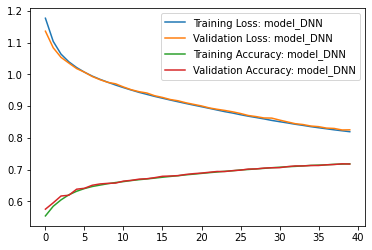

In [283]:
History(model_1.name, history_1)

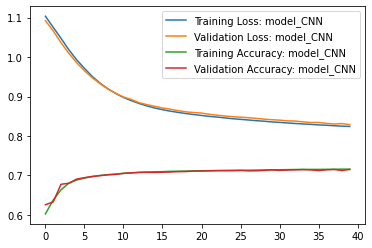

In [284]:
History(model_2.name, history_2)

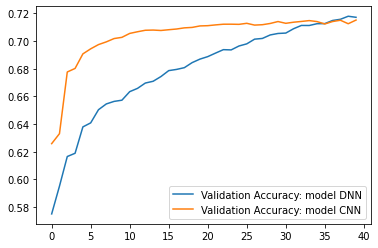

In [285]:
plt.plot( history_1.history['val_accuracy'], label = 'Validation Accuracy: model DNN')
plt.plot( history_2.history['val_accuracy'], label = 'Validation Accuracy: model CNN')
plt.legend()
plt.show()

Has the conclusion changed ?

In [286]:
print("the best model is: {}".format(model_1.name if a_1_last > a_2_last else model_2.name))

the best model is: model_DNN
